In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!gdown 1_0QUBkNcL1pS0wymlIB8MbfEEeHX5PzA > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1_0QUBkNcL1pS0wymlIB8MbfEEeHX5PzA
To: /home/mrvafa/Projects/Python/face-classification/Face_Recognition_Dataset.rar
100%|██████████████████████████████████████| 45.0M/45.0M [00:12<00:00, 3.53MB/s]


In [3]:
!unrar x Face_Recognition_Dataset.rar > /dev/null

In [4]:
!rm -rf Face_Recognition_Dataset.rar

In [5]:
import os
from PIL import Image

DATASET_PATH = os.path.join('Face_Recognition_Dataset', 'CroppedYale')

dataset = {}

for folder_name in os.listdir(DATASET_PATH):
  for file_name in os.listdir(os.path.join(DATASET_PATH, folder_name)):
    if file_name.endswith('.pgm'):
      if Image.open(os.path.join(DATASET_PATH, folder_name, file_name)).size == (168, 192):
        if folder_name not in dataset:
          dataset[folder_name] = []
        else:  
          dataset[folder_name].append(os.path.join(DATASET_PATH, folder_name, file_name))

In [6]:
import cv2
import pywt
from skimage.feature import local_binary_pattern
from datetime import datetime

radius = 3
n_points = 8 * radius

dataset_numpy = {}

start = datetime.now()
for label in dataset.keys():
  dataset_numpy[label] = []
  for file_path in dataset[label]:
    dataset_numpy[label].append(
        local_binary_pattern(cv2.imread(file_path, 0), n_points, radius).reshape((1, -1))
    )
print(f'LBP method took {datetime.now() - start}.')

LBP method took 0:00:25.609538.


In [7]:
x = []
y = []

for label in dataset_numpy.keys():
  for image in dataset_numpy[label]:
    x.append(image)
    y.append(int(label[-2:]))

In [8]:
import numpy as np

x = np.asmatrix(np.asarray(x))
y = np.asmatrix(y)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y.T, test_size=0.2, shuffle=True)

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

start = datetime.now()
lda = LDA(n_components=30)
x_train = lda.fit_transform(x_train, y_train)
print(f'LDA method took {datetime.now() - start}')
x_test = lda.transform(x_test)

LDA method took 0:00:30.246890


In [11]:
import math
from sklearn import svm, metrics
from sklearn.model_selection import KFold
from datetime import datetime
kfold = KFold(n_splits=10, shuffle=True)

best_model = None
best_accuracy = -math.inf
sum_accuracy = 0

kernels = ['sigmoid', 'rbf']

decision_function_shape_list = ['ovo', 'ovr']

counter = 0

result = dict()

for decision_function_shape in decision_function_shape_list:
  for kernel in kernels:
    for index, (train, test) in enumerate(kfold.split(x_train, y_train)):
      start = datetime.now()
      clf = svm.SVC(decision_function_shape=decision_function_shape, kernel=kernel)
      clf.fit(x_train[train], y_train[train])
      model_build_duration = datetime.now() - start
      y_hat = clf.predict(x_train[test])
      accuracy = metrics.accuracy_score(y_hat, y_train[test])

      sum_accuracy += accuracy

      if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_model = clf
      
      result[counter] = {
          'duration': model_build_duration,
          'kernel': kernel,
          'accuracy': accuracy,
          'decision_function_shape': decision_function_shape
      }

      counter += 1

print('best_accuracy', best_accuracy)
print('avg_accuracy', sum_accuracy / counter)

best_accuracy 1.0
avg_accuracy 0.9943662165885918


In [12]:
print('Model properties')
print(best_model.kernel)
print(best_model.decision_function_shape)

Model properties
rbf
ovr


0.9937238493723849


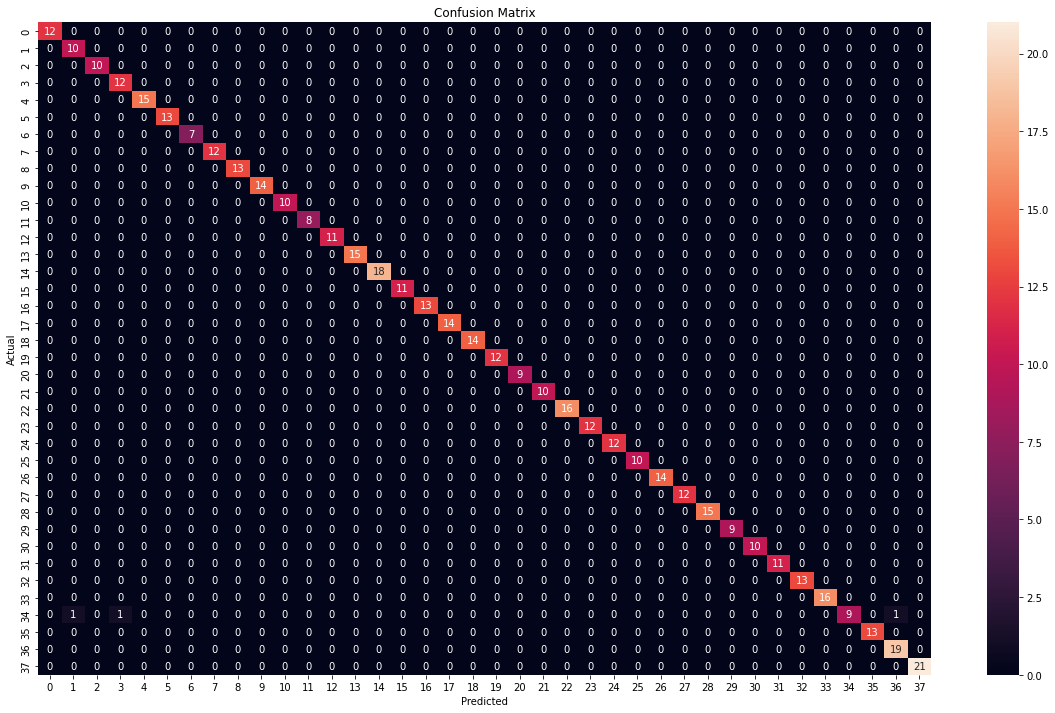

In [13]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import confusion_matrix
import seaborn as sb


y_hat = best_model.predict(x_test)

print(metrics.accuracy_score(y_hat, y_test))

matrix = confusion_matrix(y_hat, y_test)

plt.subplots(figsize=(20, 12))
sb.heatmap(matrix, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

np.set_printoptions(precision=2)
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      0.91      0.95        11
           3       1.00      1.00      1.00        10
           4       1.00      0.92      0.96        13
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        13
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00        11
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        18
          17       1.00      1.00      1.00        11
          18       1.00      1.00      1.00        13
          19       1.00    

In [15]:
average_model_creation = 0
for item in result.items():
    average_model_creation += item[1]['duration'].microseconds
average_model_creation /= len(result)
print(f'Average model creating is {average_model_creation / 1_000_000} seconds.')

Average model creating is 0.062262475 seconds.
